In [22]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #[0,255] to [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # image pixel = (image pixel - mean)/std
    #[-1,1]
valid_size = 0.2

In [23]:
trainset = datasets.CIFAR10('Cifar10',download=True, train=True, transform=transform)
testset = datasets.CIFAR10('Cifar10',download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


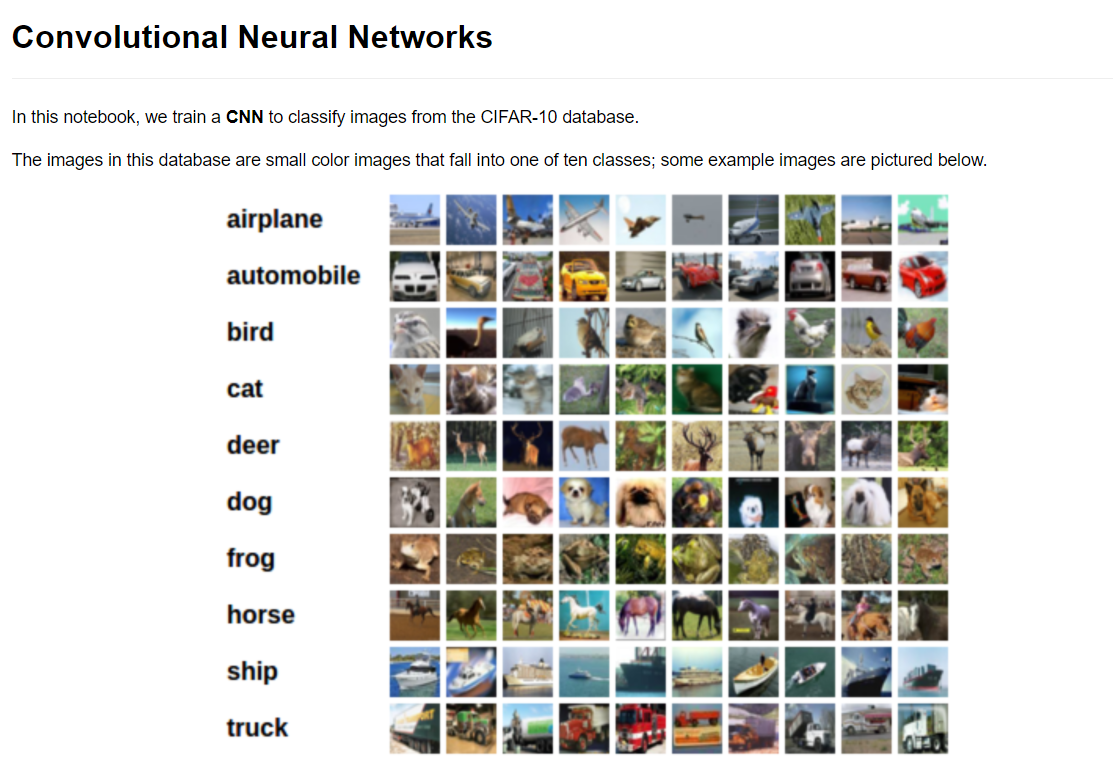

In [24]:
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(num_train*valid_size))
train_idx, valid_idx = indices[split:], indices[:split]

In [25]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=train_sampler, num_workers=0)
validloader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=valid_sampler, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, num_workers=0)

In [27]:
%matplotlib inline

def imshow(x):
    x = x/2+0.5
    plt.imshow(np.transpose(x,(1,2,0)))
    
    #[1,2,3]->[2,3,1] 

In [28]:
dataiterator = iter(trainloader)
images, labels = dataiterator.next()
images = images.numpy()

print(labels)
print(images.shape)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

tensor([3, 9, 5, 5, 7, 8, 1, 9, 2, 0, 0, 8, 9, 3, 4, 9, 2, 6, 1, 0])
(20, 3, 32, 32)


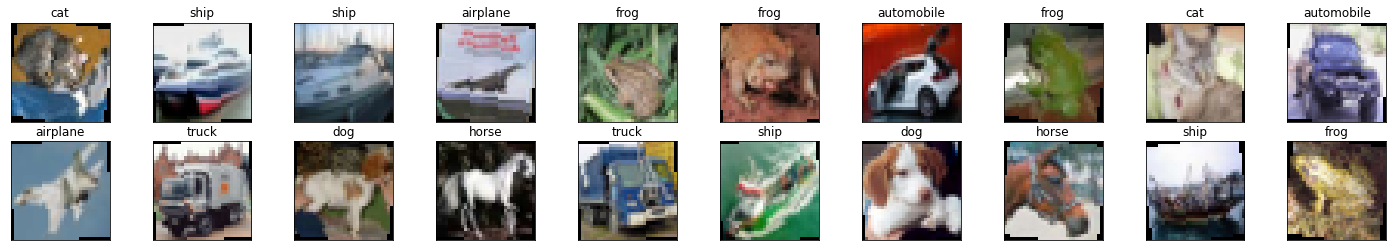

In [48]:
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
    img = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    imshow(images[i])
    img.set_title(classes[labels[i]])

In [30]:
device = torch.cuda.is_available()

if device:
    print("The model trains on GPU")
else:
    print("The model trains on CPU")

The model trains on CPU


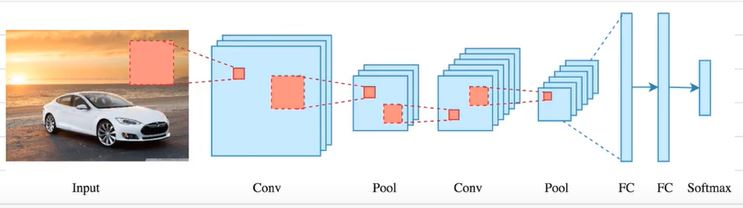

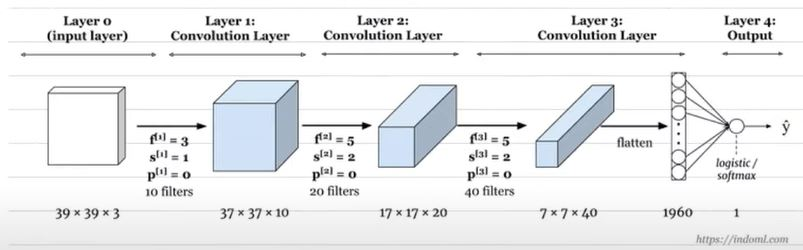

In [31]:
from torch import nn,optim
import torch.nn.functional as F

In [32]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,16,3,padding=1)  
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.hidden1 = nn.Linear(4*4*64, 512)
        self.hidden2 = nn.Linear(512,256)
        self.output = nn.Linear(256,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        # nh' = ((nh - f + 2*p)/s) + 1
        # nh' = ((32 - 3 + 2*1)/1)+1 = 32*32*16
        x = self.pool(x)
        #nh' = 32/2 = 16*16*16
        x = F.relu(self.conv2(x))
        #nh' = ((16-3+2*1)/1)+1 = 16*16*32
        x = self.pool(x)
        #nh' = 16/2 = 8*8*32
        x = F.relu(self.conv3(x))
        #nh' = ((8-3+2*1)/1)+1 = 8*8*64
        x = self.pool(x)
        #nh' = 8/2 = 4*4*64
        
        x = x.view(-1, 4*4*64)
        #4*4*64 = 1024
        
        x = self.dropout(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        
        return x

In [33]:
model = Classifier()
model

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [34]:
if device:
    model.cuda()

In [35]:
criterion = nn.CrossEntropyLoss()
#Log_softmax() function
#nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [39]:
n_epochs = 10

valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for images, labels in trainloader:
        if device:
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
    
        output = model(images)

        loss = criterion(output, labels)

        loss.backward()
        
        optimizer.step()
    
        train_loss += loss.item()*images.size(0)
    model.eval()
    for images, labels in validloader:
        
        if device:
            images, labels = images.cuda(), labels.cuda()
        
        output = model(images)
        
        loss = criterion(output, labels)

        valid_loss += loss.item()*images.size(0)
    

    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
        

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.295785 	Validation Loss: 2.239880
Validation loss decreased (inf --> 2.239880).  Saving model ...
Epoch: 2 	Training Loss: 2.010004 	Validation Loss: 1.833550
Validation loss decreased (2.239880 --> 1.833550).  Saving model ...
Epoch: 3 	Training Loss: 1.724352 	Validation Loss: 1.570601
Validation loss decreased (1.833550 --> 1.570601).  Saving model ...
Epoch: 4 	Training Loss: 1.550913 	Validation Loss: 1.439256
Validation loss decreased (1.570601 --> 1.439256).  Saving model ...
Epoch: 5 	Training Loss: 1.438984 	Validation Loss: 1.349359
Validation loss decreased (1.439256 --> 1.349359).  Saving model ...
Epoch: 6 	Training Loss: 1.351772 	Validation Loss: 1.307789
Validation loss decreased (1.349359 --> 1.307789).  Saving model ...
Epoch: 7 	Training Loss: 1.272875 	Validation Loss: 1.201368
Validation loss decreased (1.307789 --> 1.201368).  Saving model ...
Epoch: 8 	Training Loss: 1.205705 	Validation Loss: 1.156611
Validation loss decreased (1.20136

In [46]:
print(model.state_dict)

<bound method Module.state_dict of Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


In [40]:
loader = torch.load("cifar_model.pt")
model.load_state_dict(loader)

<All keys matched successfully>

In [49]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in testloader:
    
    if device:
        images, labels = images.cuda(), labels.cuda()
    
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(labels.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(20):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.037049

Test Accuracy of airplane: 68% (680/1000)
Test Accuracy of automobile: 74% (744/1000)
Test Accuracy of  bird: 51% (511/1000)
Test Accuracy of   cat: 46% (464/1000)
Test Accuracy of  deer: 50% (509/1000)
Test Accuracy of   dog: 62% (624/1000)
Test Accuracy of  frog: 61% (610/1000)
Test Accuracy of horse: 71% (718/1000)
Test Accuracy of  ship: 81% (817/1000)
Test Accuracy of truck: 64% (641/1000)

Test Accuracy (Overall): 63% (6318/10000)


E:\Installed_Softwares\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


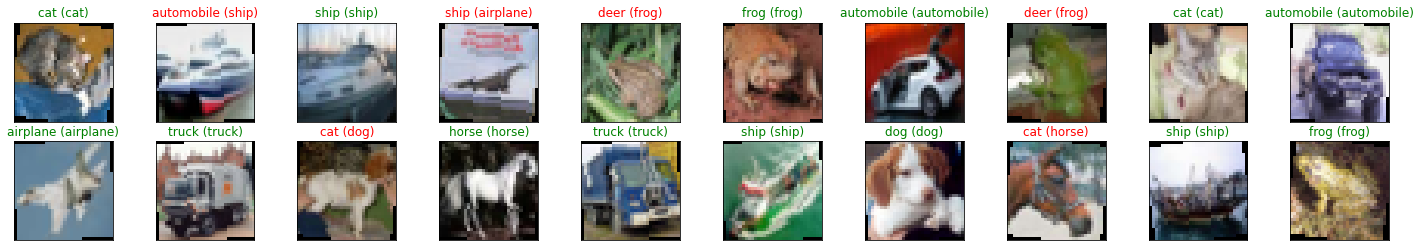

In [42]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

if device:
    images = images.cuda()

output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))